## Objetivo: 

Dada uma base de dados que contêm resultados de diversos jogos de Counter Strike, com variáveis coletadas nos jogos e os resultados de quem ganhou cada round. Será criado um modelo que permita prever quem irá ganhar um round de um jogo.

In [78]:
import pandas as pd 
import numpy as np 
import plotly.express as px
import matplotlib.pyplot as plt

## Importando o Dataset

In [79]:
df = pd.read_csv('csgo_round_snapshots.csv')

## Explorando o Dataset

In [80]:
# Análise Descritiva

df.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


#### Verificando dados nulos

In [81]:
df_nan = pd.DataFrame(df.isnull().sum().reset_index().rename(columns= { 0:'total_nan', 'index':'variável'}))
df_nan

,variável,total_nan
0,time_left,0
1,ct_score,0
2,t_score,0
3,map,0
4,bomb_planted,0
...,...,...
92,ct_grenade_molotovgrenade,0
93,t_grenade_molotovgrenade,0
94,ct_grenade_decoygrenade,0
95,t_grenade_decoygrenade,0


In [82]:
df_nan[df_nan['total_nan']>0]

,variável,total_nan


#### Estudando variáveis categóricas

In [83]:
# Separando variávies qualitativas e quantitativas em diferentes dataframes

cols = df.dtypes.reset_index().rename(columns={'index': 'coluna', 0:'tipo'})
categ_cols = cols[cols['tipo'] == 'object']
cont_cols = cols[cols['tipo'] != 'object']

In [84]:
# Há apenas duas variáveis qualitativas no dataset, o mapa em que a partida foi jogada, e o time vencedor da partida

categ_cols

,coluna,tipo
3,map,object
96,round_winner,object


In [85]:
# Entendendo os tipos de valores na variável 'round_winner', sendo: 'CT' = Contra Terrorista, e 'T' = Terrorista

df['round_winner'].unique()

array(['CT', 'T'], dtype=object)

In [86]:
cont_cols

,coluna,tipo
0,time_left,float64
1,ct_score,float64
2,t_score,float64
4,bomb_planted,bool
5,ct_health,float64
...,...,...
91,t_grenade_incendiarygrenade,float64
92,ct_grenade_molotovgrenade,float64
93,t_grenade_molotovgrenade,float64
94,ct_grenade_decoygrenade,float64


In [87]:
# Verificando os diferentes dtypes existentes no dataframe variáveis quantitativas
cont_cols['tipo'].unique()

array([dtype('float64'), dtype('bool')], dtype=object)

In [88]:
# Para futura aplicação do modelo, o ideial é não ter variáveis do tipo 'boolean', sendo assim:
# Verificamos quantas variáveis são do tipo 'boolean', para decidir o que fazer com as mesmas

cont_cols[cont_cols['tipo'] == 'bool']

,coluna,tipo
4,bomb_planted,bool


In [89]:
# Apenas a variável 'bomb_planted' é do tipo 'boolean', sendo assim, será transformado para o tipo 'int'
df['bomb_planted'] = df['bomb_planted'].astype(int)

## Verificando Outliers

In [90]:
# Por algumas variáveis terem dimensões muito diferentes, não se torna viável, utilizar o método do bloxpot

df.boxplot()

<AxesSubplot: >

In [91]:
# Utilizando o método interquartil para verificar outliers

nomes_colunas = []
qtt_outliers = []

for v in cont_cols.coluna:
    
    contador = 0

    q1 = np.quantile(df[v], 0.25)
    q3 = np.quantile(df[v], 0.75)
    li = q1 - 1.5*(q3-q1)
    ls = q3 + 1.5*(q3-q1)

    for i in df.index:
        if li <= df[v][i] <= ls:
            pass 
        else:
            contador += 1
    
    percent_outliers = (contador/df[v].count())*100

    nomes_colunas.append(v)
    qtt_outliers.append(percent_outliers)
    # df = df.drop(i, axis = 0) # exclui todos os valores dados como outliers

In [92]:
# Visualizando apenas as outliers que correspondem à mais de 10% da quantidade de linhas

outliers = pd.DataFrame()
outliers['coluna'] = nomes_colunas
outliers['percent_outliers'] = qtt_outliers
outliers[outliers['percent_outliers'] > 10]

# Por haver diversas variáveis com um valor maior de 10%, não serão excluídas no momento, por representarem uma significativa quantidade de dados do dataset

,coluna,percent_outliers
3,bomb_planted,11.178825
13,ct_players_alive,12.626419
14,t_players_alive,11.955723
15,ct_weapon_ak47,21.308717
17,ct_weapon_aug,10.071073
23,ct_weapon_cz75auto,12.320072
49,ct_weapon_mp9,10.812025
63,ct_weapon_sg553,18.546687
64,t_weapon_sg553,10.758925
72,t_weapon_deagle,23.721918


## Tratamento de Variáveis Categóricas

In [93]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()

for i in categ_cols.coluna:
    df[str(i) + '_encoded'] = le.fit_transform(df[i])

In [94]:
# no cmd, para atualizar o pip: python.exe -m pip install --upgrade pip
# pip install scikit-learn

In [95]:
df[['round_winner', 'round_winner_encoded']]

# Após o tratamento das variáveis utilizando o LabelEncoder, o resultado é o seguinte: 'CT' = 0 e 'T' = 1

,round_winner,round_winner_encoded
0,CT,0
1,CT,0
2,CT,0
3,CT,0
4,CT,0
...,...,...
122405,T,1
122406,T,1
122407,T,1
122408,T,1


In [96]:
# Excluindo colunas categóricas tratadas, as quais não podem ser usadas para treino do modelo

df.drop(['round_winner', 'map'], axis = 1, inplace = True)

## Separando o Dataset entre Treino e Teste

In [97]:
from sklearn.model_selection import train_test_split

# X é igual ao dataframe sem a informação de qual time foi o vencedor de cada partida, o qual será usado para treinar o modelo
x = df.drop('round_winner_encoded', axis = 1)
# Y é igual as informações de quais times foram os vencedores de cada partida, o qual será usado para testar o modelo
y = df['round_winner_encoded']

#### Padronizando as Variáveis de Entrada do Modelo

Como citado anteriormente, as dimensões de algumas variáveis estão muito diferentes, por isso, será feito o escalonamento desses valores,
com o objetivo de evitar um impacto negativo nos resultados do modelo a ser treinado

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_scaled = scaler.fit_transform(x)

In [99]:
# O resultado retornado é em forma de array, para isso:

x_scaled = pd.DataFrame(x_scaled, columns=(x.columns))

In [100]:
# É possível verificar que, após o tratamento acima, as variáveis possuem a mesma escala

x_scaled

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,map_encoded
0,1.415828,-1.400576,-1.405702,-0.354764,0.664386,0.695301,-1.836777,-1.709542,-0.516186,-0.595345,...,-1.035461,-0.886648,-0.889569,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,-1.306410
1,1.067531,-1.400576,-1.405702,-0.354764,0.664386,0.695301,0.502008,0.008909,-0.819351,-0.870776,...,-1.035461,-0.886648,0.203841,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,-1.306410
2,-0.034094,-1.400576,-1.405702,-0.354764,-0.159544,-0.019401,-0.117770,-0.563908,-0.805977,-0.883109,...,-1.035461,-0.886648,0.203841,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,-1.306410
3,-0.401302,-1.400576,-1.405702,-0.354764,-0.159544,-0.019401,-0.117770,-0.563908,-0.805977,-0.883109,...,-1.035461,-0.886648,-0.889569,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,-1.306410
4,1.415277,-1.191823,-1.405702,-0.354764,0.664386,0.695301,-0.714160,-1.709542,0.763351,-0.040372,...,-1.035461,-0.886648,-0.889569,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,-1.306410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,-1.514310,0.895711,1.496741,2.818773,-1.603312,-1.148630,-0.696619,0.346871,-0.863935,-0.435020,...,0.079077,-0.311206,-0.342864,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,1.285498
122406,1.414542,0.895711,1.704058,-0.354764,0.664386,0.695301,-1.281315,-0.707112,0.152561,1.040797,...,0.079077,-0.311206,-0.889569,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,1.285498
122407,0.312918,0.895711,1.704058,-0.354764,0.664386,0.695301,1.057469,1.011339,-0.765852,-0.373356,...,1.193615,0.839676,1.843956,-0.001350,-0.137694,-0.210881,2.193253,-0.163356,-0.156855,1.285498
122408,-0.054290,0.895711,1.704058,-0.354764,0.664386,0.695301,1.057469,1.011339,-0.765852,-0.373356,...,1.750884,-0.886648,0.750546,-0.687185,-0.137694,-0.210881,1.592017,-0.163356,-0.156855,1.285498


#### Divisão do Dataframe

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 42)

# Foi atribuido valor em 'random_state', para que os valores possam ser reproduzidos, e não sempre aleatórios

## Treinando e Avaliando Modelos

#### Regressão Logística

In [102]:
from sklearn.linear_model import LogisticRegression

# Criando o modelo de Regressão Logística
lr_model = LogisticRegression()

# Treinando o modelo
lr_model.fit(x_train, y_train)

# Criando a variável de valores previstos pelo modelo
lr_y_pred = lr_model.predict(x_test)

In [103]:
lr_y_pred

array([0, 1, 0, ..., 1, 0, 1])

In [104]:
# Avaliando o desempenho
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Verificando a acurácia do modelo
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print(f'Acurácia do modelo de Regressão Logística: {lr_accuracy*100:.2f}%')

# F1 Score: média harmônica da precisão e recall, para avaliar o equilíbrio entre as duas métricas
lr_f1 = f1_score(y_test, lr_y_pred)
print(f'O valor de F1 Score do modelo foi de: {lr_f1}')

# Matriz de Confusão 
lr_cm = confusion_matrix(y_test, lr_y_pred)

Acurácia do modelo de Regressão Logística: 74.98%
O valor de F1 Score do modelo foi de: 0.7510263810414212


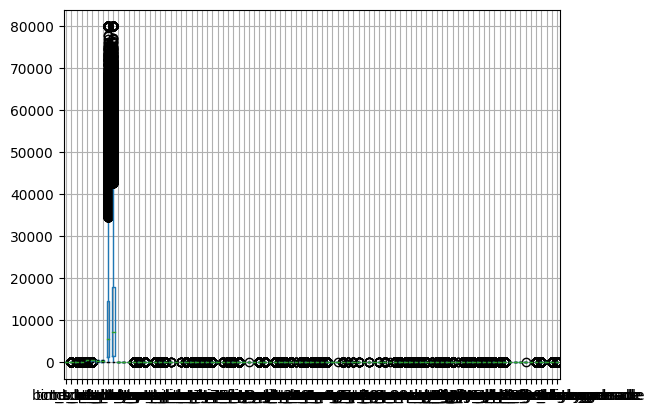

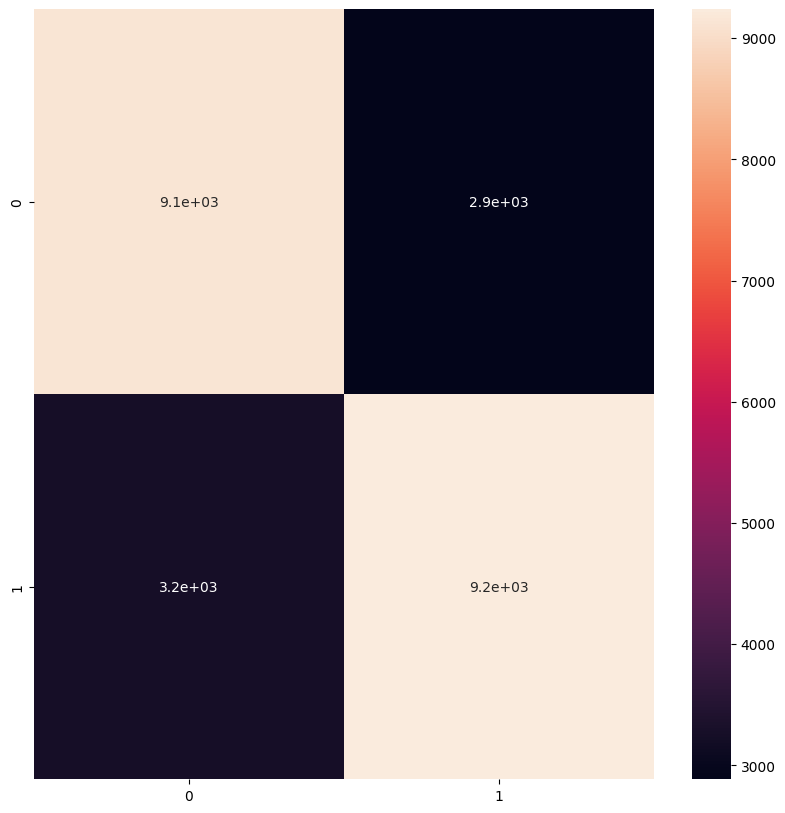

In [105]:
# Visualização da Matriz
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(lr_cm, annot = True)

plt.show()

#### Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier

# Criando o modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
rf_model.fit(x_train, y_train)

# Fazendo previsões para o conjunto de teste
rf_y_pred = rf_model.predict(x_test)

In [107]:
# Avaliando o desempenho

# Verificando a acurácia do modelo
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Acurácia do modelo de Random Forest: {rf_accuracy*100:.2f}%')

# F1 Score: média harmônica da precisão e recall, para avaliar o equilíbrio entre as duas métricas
rf_f1 = f1_score(y_test, rf_y_pred)
print(f'O valor de F1 Score do modelo foi de: {rf_f1}')

# Matriz de Confusão 
rf_cm = confusion_matrix(y_test, rf_y_pred)

Acurácia do modelo de Random Forest: 87.82%
O valor de F1 Score do modelo foi de: 0.8791048406713694


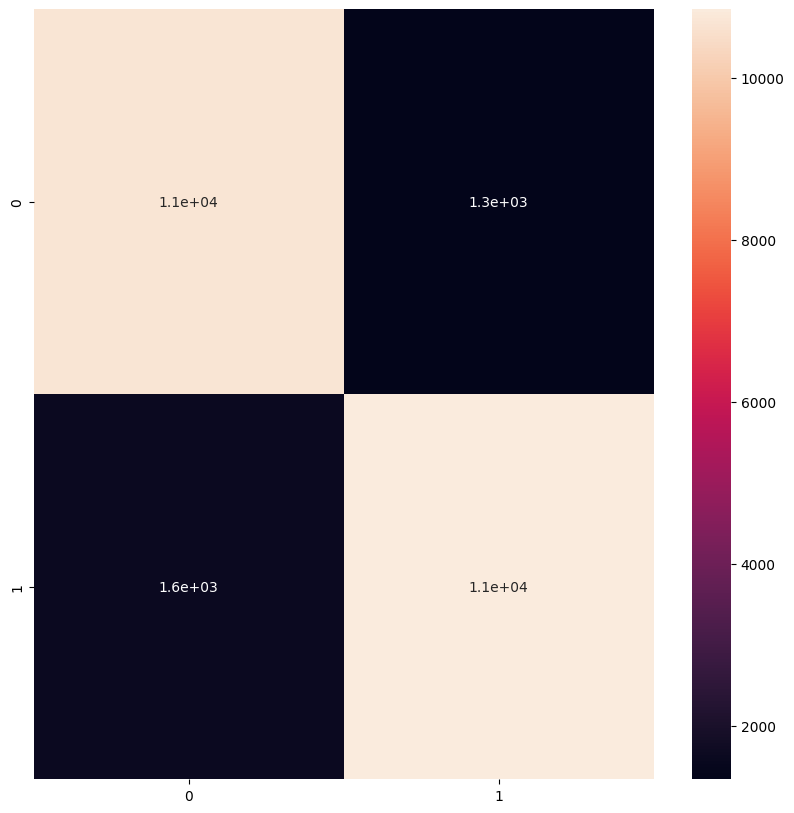

In [108]:
# Visualização da Matriz de Confusão

import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(rf_cm, annot = True)

plt.show()

#### Árvore de Decisão

In [109]:
from sklearn.tree import DecisionTreeClassifier

# Criando o modelo de Random Forest
dt_model = DecisionTreeClassifier()

# Treinando o modelo
dt_model.fit(x_train, y_train)

# Fazendo previsões para o conjunto de teste
dt_y_pred = dt_model.predict(x_test)

In [110]:
# Avaliando o desempenho

# Verificando a acurácia do modelo
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print(f'Acurácia do modelo de Árvore de Decisão: {dt_accuracy*100:.2f}%')

# F1 Score: média harmônica da precisão e recall, para avaliar o equilíbrio entre as duas métricas
dt_f1 = f1_score(y_test, dt_y_pred)
print(f'O valor de F1 Score do modelo foi de: {dt_f1}')

# Matriz de Confusão 
dt_cm = confusion_matrix(y_test, dt_y_pred)

Acurácia do modelo de Árvore de Decisão: 81.92%
O valor de F1 Score do modelo foi de: 0.8223158739715032


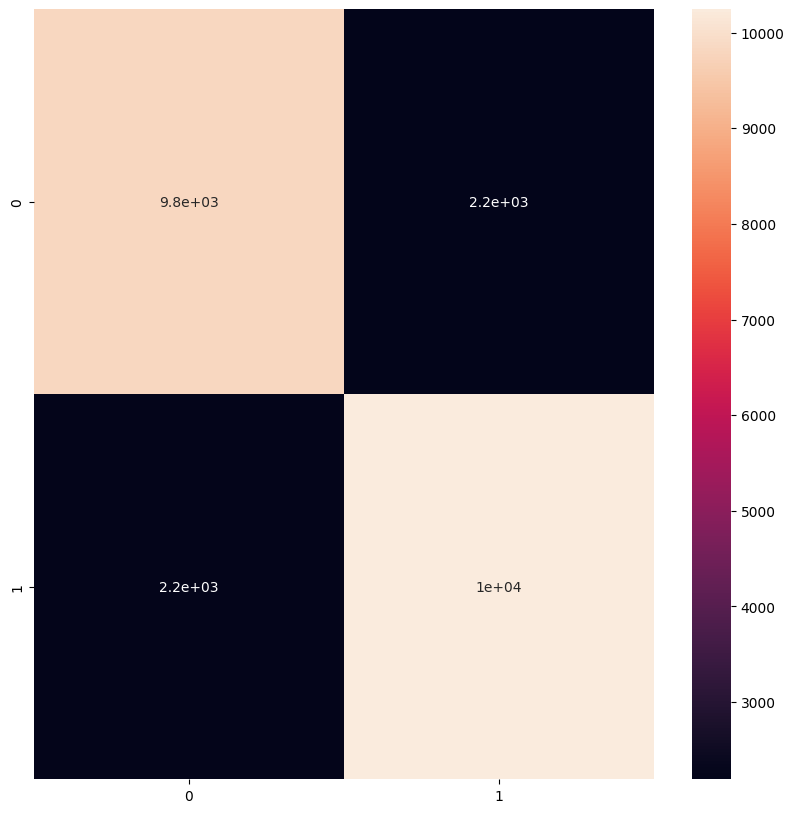

In [111]:
# Visualização da Matriz de Confusão

import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(dt_cm, annot = True)

plt.show()

## Conclusão

Dentre os 3 modelos supervisionados de machine learning utilizados neste caso (Regressão Logística, Random Forest e Árvore de Decisão), o modelo de Random Forest se saiu melhor, 
o qual obteve o maior valor de acurácia (87.82%) em relação aos outros dois modelos (74.98% para Regressão Logística, e 81.90% para Árvore de Decisão).